#Background
We first tried to create an unsupervised learning approach, by which we can tell if a review is positive or negative. For that end we used Doc2Vec model to transform text into vector representation. 

We then proceeded to fit a gaussian distribution over the vector representation of good reviews, hoping that bad reviews would have different probabilistic distribution allowing us to spot them. 

When the first approach failed, we implemented another approach in which we used an Autoencoder, to find a latent low dimension representation of good reviews, again hoping that bad reviews would lead to high reconstruction error allowing us to spot them. 

When that approach also failed we started thinking that maybe the data itself has no statistical difference between good and bad reviews. This is why we created this Notebook to explore this possibility and indeed showing that this is the case

These trials are found under Anomaly-Detection

# Text preprocessing
Here are utilities methods for text-preprocessing and calculating cosine similarities that we would need later

In [40]:
from gensim import utils
import gensim.parsing.preprocessing as gsp


from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = cosine(vectors[i], predicted_vectors[i])
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(data_df, sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Review: ', data_df.iloc[index, 1])  
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')


filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def text_preprocessing(review):
    review = review.lower()
    review = utils.to_unicode(review)
    for filter in filters:
        review = filter(review)
    
    return review


# Doc2Vec
Here we transform input text into vector representation of length 300. This is done using the Doc2Vec model.

In [41]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm
import multiprocessing
import numpy as np
from os import path

def doc2Vec_generator(data_df):
    #If model is not saved, create a Doc2Vec model, train it on our data, transform our reviews to vectors then save both model and vectors
    if (not (path.exists("./model")  or path.exists("vectors.npy")  )):
        for row in data_df.itertuples():
            data_df.at[row.Index, 'REVIEW_TEXT'] = text_preprocessing(row.REVIEW_TEXT)

        doc2vec_transformer = Doc2VecTransformer(vector_size=300)

        doc2vec_transformer.fit(data_df)

        doc2vec_vectors = doc2vec_transformer.transform(data_df)

        np.save("./vectors.npy", doc2vec_vectors)
        doc2vec_transformer._model.save("./model")
    #load model and and transform data into vectors
    else:
        #doc2vec_vectors = np.load("./vectors.npy")
        doc2vec_transformer = Doc2VecTransformer(vector_size=300, model=Doc2Vec.load("./model"))
        doc2vec_vectors = doc2vec_transformer.transform(data_df)
    
    return doc2vec_transformer, doc2vec_vectors

class Doc2VecTransformer(BaseEstimator):
    def __init__(self, vector_size=100, model=None, learning_rate=0.02, epochs=20):
        self.vector_size = vector_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = model
        self.workers = multiprocessing.cpu_count()-1
    
    def fit(self, df_x, df_y=None):
        tagged_x = [ TaggedDocument(  str(row.REVIEW_TEXT).split() , [row.Index]   )     for row in df_x.itertuples()      ]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            training_data = [review for review in tqdm(tagged_x)]
            model.train(skl_utils.shuffle(training_data),  total_examples=len(training_data), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model

        return self
    
    def transform(self, df_x):
        #return np.asmatrix ( np.array( [ self._model.infer_vector(  str(row.REVIEW_TEXT).split()  ) 
        #              for row in df_x.itertuples() ])
        #            )
        return np.array( [ self._model.infer_vector(  str(row.REVIEW_TEXT).split()  ) 
                      for row in df_x.itertuples() ])

    
    def transform_string(self, review):
        review = text_preprocessing(review)
        vector = self._model.infer_vector( str(review).split() )
        return np.array( [vector] )

# Reading and transforming data to vectors

In [42]:
!pip install wget

In [43]:
from gensim.models.doc2vec import Doc2Vec
import pandas as pd
#from utils import text_preprocessing
#from doc2VecTransformer import Doc2VecTransformer, doc2Vec_generator
from sklearn.covariance import EllipticEnvelope
import numpy as np

from scipy.stats import multivariate_normal
from scipy.spatial import distance
from scipy.stats import chi2
from os import path
import os
import wget
import shutil

In [44]:
if not os.path.isfile('amazon_reviews.txt'):
    url = 'https://drive.google.com/uc?id=1-LYI_s6oZ0OTe3I0vFYRYIBVhjFswReY&export=download' # downloads db to train
    print('Downloading DB to train')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('amazon_reviews.zip')

In [45]:
# We want to take the reviews data from the 21k examples, extract the positive data and then use Doc2Vec to get the vectors
#data = pd.read_csv('/content/sample_data/amazon_reviews.txt', delimiter="\t", error_bad_lines=False)

data = pd.read_csv('amazon_reviews.txt', delimiter="\t", error_bad_lines=False)

features = ['RATING', 'REVIEW_TEXT']
data_true = data[  data['LABEL'] == '__label1__' ]
data_shortened = data_true[features]

# We extract positive and negative reviews
data_pos = data_shortened[  data_shortened['RATING'] == 5 ]
data_neg = data_shortened[data_shortened['RATING'] == 1]


#If you are running for first time delete model and vectors.npy (in case you want to train the model on different data)
doc2vec_transformer, doc2vec_vectors = doc2Vec_generator(data_pos)


#Scale vectors to avoid overflow
doc2vec_vectors *= 1000

In [46]:
print(type(doc2vec_vectors))
print(doc2vec_vectors.shape)

<class 'numpy.ndarray'>
(6059, 300)


In [47]:
import pandas as pd
#Turn numpy array to pandas dataframe
num_features = doc2vec_vectors.shape[1]
feat_cols = [f'feature{i}' for i in range(num_features)  ]
df = pd.DataFrame(data=doc2vec_vectors, columns=feat_cols)

print(df.head())

    feature0  feature1   feature2  ...  feature297  feature298  feature299
0  -0.676288  0.613152  -1.060689  ...   -0.940683    1.307610   -0.946886
1  -0.823472 -1.368364   1.311051  ...    1.425232    1.565418   -1.584115
2 -32.098213 -7.269979  48.449509  ...   -7.563104    9.863148  -39.961552
3   1.195127  1.524978  -1.164653  ...   -1.068136    0.697125    2.388207
4   0.269153 -0.798108   1.409733  ...    1.193083   -1.506155    0.019794

[5 rows x 300 columns]


# Dimensionality Reduction and plotting
We reduce the 300 dimension vectors to 2D vectors for visualization using PCA. 

We create a pandas dataframe including both positive and negative reviews, and plot them on a 2D plane. We see that there is no significant statistical difference in the distribution of the data, which explains why our unsupervised learning approaches failed to separate between them.

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]

<Figure size 1152x720 with 0 Axes>

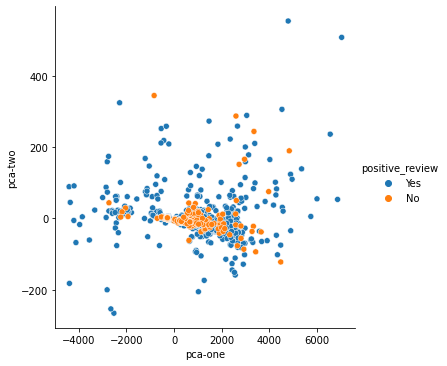

In [49]:
# We create the vector representation of negative reviews
doc2vec_transformer_neg, doc2vec_vectors_neg = doc2Vec_generator(data_neg)

#Scale vectors to avoid overflow
doc2vec_vectors_neg *= 1000

df['positive_review'] = df.apply(lambda x: 'Yes', axis=1)

num_features = doc2vec_vectors_neg.shape[1]
feat_cols_neg = [f'feature{i}' for i in range(num_features)  ]
df_neg = pd.DataFrame(data=doc2vec_vectors_neg, columns=feat_cols_neg)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_neg[feat_cols_neg].values)
df_neg['pca-one'] = pca_result[:,0]
df_neg['pca-two'] = pca_result[:,1]

df_neg['positive_review'] = df.apply(lambda x: 'No', axis=1)


df_all = pd.concat([df, df_neg], axis= 0)


plt.figure(figsize=(16,10))
sns.relplot(x='pca-one', y='pca-two', data=df_all, hue='positive_review')

# Extra
## Distribution of Fake vs Real reviews

In [ ]:
features = ['RATING', 'REVIEW_TEXT', 'VERIFIED_PURCHASE', 'LABEL']


data_shortened = data[features]

data_shortened['VERIFIED_PURCHASE'] = data_shortened['VERIFIED_PURCHASE'].replace('N', 0)
data_shortened['VERIFIED_PURCHASE'] = data_shortened['VERIFIED_PURCHASE'].replace('Y', 1)

data_shortened['LABEL'] = data_shortened['LABEL'].replace('__label1__', 'Real')
data_shortened['LABEL'] = data_shortened['LABEL'].replace('__label2__', 'Fake')

In [51]:

doc2vec_transformer, doc2vec_vectors = doc2Vec_generator(data_shortened)
#Scale vectors to avoid overflow
doc2vec_vectors *= 1000

num_features = doc2vec_vectors.shape[1]
feat_cols = [f'feature{i}' for i in range(num_features)  ]
df = pd.DataFrame(data=doc2vec_vectors, columns=feat_cols)

df['LABEL'] = data_shortened['LABEL']



In [52]:
df.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,...,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,LABEL
0,-78.973717,-21.769327,128.031464,45.746765,-105.191727,53.637287,39.508366,-93.150299,-53.933895,105.896759,-112.163940,101.860359,42.058136,-38.049026,36.742691,-170.773163,40.198689,57.851379,-117.612915,43.186489,16.972004,117.936203,21.287649,-77.333626,-147.201538,-77.385956,108.258492,-132.780029,24.279377,-146.391708,-10.076248,133.103897,122.521751,-29.235010,-74.722794,26.613852,37.901474,-89.184036,-18.908102,135.399414,...,12.886898,57.527908,-62.833355,-7.555753,114.121811,-73.101303,39.247314,-73.307129,-134.663101,-41.102272,-83.598351,66.561813,-42.954369,-135.048645,-60.941799,23.458279,-33.974140,79.330666,-8.815299,-56.092735,103.911896,-92.732590,25.256821,82.384254,-86.267586,-16.436899,8.953679,-79.928627,-8.446653,-43.720615,-84.181992,16.170174,87.937210,20.712645,108.700882,-29.236698,-20.001017,26.759777,-99.445984,Real
1,-64.506958,-16.074255,101.328613,36.715084,-86.285141,43.549934,30.762611,-77.883469,-43.906734,83.059464,-89.054726,84.430466,33.578384,-28.536919,29.257214,-135.870590,34.439644,50.225513,-97.402855,31.413351,13.642901,92.804108,16.524197,-64.748962,-116.365074,-64.682594,89.291283,-106.434784,19.197186,-115.687210,-6.872636,105.376137,97.157303,-25.591795,-55.563877,20.144766,32.673489,-72.492126,-15.851445,110.843307,...,10.467874,48.637718,-50.300575,-6.129702,92.776558,-58.706146,32.506081,-62.135620,-107.263756,-29.445967,-65.123131,53.133884,-36.109123,-106.599266,-48.814072,16.303829,-29.059874,61.740879,-6.984689,-43.957104,85.110565,-73.437447,22.737309,64.913200,-69.906021,-13.846940,9.647378,-63.315063,-6.447096,-34.578197,-68.112495,13.115638,69.781181,17.278994,88.112404,-21.788252,-17.720659,23.990416,-83.880653,Real
2,-27.196613,-8.542520,42.895714,16.925087,-38.734341,16.886520,15.329216,-34.456703,-19.072165,36.799965,-39.269455,34.774040,14.452257,-12.860074,14.241279,-60.926811,13.983624,22.518290,-40.993549,13.221957,5.169308,40.859474,8.815976,-25.837461,-50.396328,-28.988775,38.267555,-48.824238,7.491932,-50.487057,-2.384876,45.281498,43.280235,-9.746044,-24.622492,11.493114,13.986486,-32.498291,-5.770207,47.552826,...,3.793832,21.212490,-23.385036,-0.861212,41.856590,-25.978512,14.852946,-27.552465,-46.853271,-12.511580,-27.725206,24.213142,-14.375449,-47.272354,-21.262253,9.226364,-11.940615,28.237703,-3.679824,-19.038403,37.336704,-33.422405,10.380939,29.811230,-29.040167,-6.684238,5.378427,-29.241581,-1.310778,-16.418398,-27.776794,6.403199,31.991146,7.530470,38.438873,-8.673824,-6.140673,8.577952,-36.203148,Real
3,-1.523788,-0.809374,-0.712362,1.445508,-1.177253,-0.490316,0.883114,0.496676,-0.540635,1.023445,-0.732419,-0.024462,-1.089479,-1.400172,0.975942,-0.858145,-0.501230,-1.374547,0.281255,-0.295424,1.531226,0.184667,0.193286,-1.166434,1.166764,1.489485,-1.033921,-1.515807,0.253388,-0.699436,1.390304,1.400369,-0.381772,0.929357,0.576881,0.063964,0.394252,0.609945,-1.432713,0.110986,...,-1.213122,-0.092801,-0.156002,1.046924,-1.278625,-1.526674,-0.096970,1.280710,1.090672,-0.605976,-0.213517,-1.053774,1.212959,0.203491,1.386186,-0.701415,0.704383,1.015727,0.234264,-0.632076,-1.078054,0.185157,-1.579848,-0.419959,0.525962,0.831565,-0.659

<Figure size 1152x720 with 0 Axes>

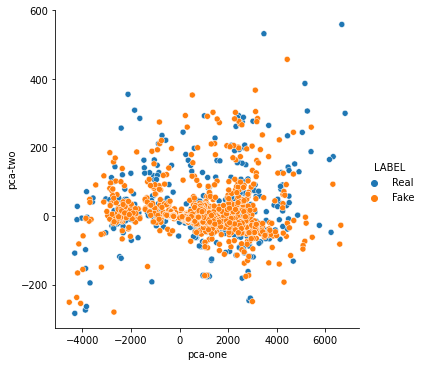

In [53]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]

plt.figure(figsize=(16,10))
sns.relplot(x='pca-one', y='pca-two', data=df, hue='LABEL')

## Trying to represent the data with t-SNE instead of PCA


In [54]:
from sklearn.manifold import TSNE
data_tsne = df[feat_cols].values
#print(df_tsne)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21000 samples in 0.718s...
[t-SNE] Computed neighbors for 21000 samples in 162.808s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21000
[t-SNE] Computed conditional probabilities for sample 2000 / 21000
[t-SNE] Computed conditional probabilities for sample 3000 / 21000
[t-SNE] Computed conditional probabilities for sample 4000 / 21000
[t-SNE] Computed conditional probabilities for sample 5000 / 21000
[t-SNE] Computed conditional probabilities for sample 6000 / 21000
[t-SNE] Computed conditional probabilities for sample 7000 / 21000
[t-SNE] Computed conditional probabilities for sample 8000 / 21000
[t-SNE] Computed conditional probabilities for sample 9000 / 21000
[t-SNE] Computed conditional probabilities for sample 10000 / 21000
[t-SNE] Computed conditional probabilities for sample 11000 / 21000
[t-SNE] Computed conditional probabilities for sample 12000 / 21000
[t-SNE] Computed conditional probabilities for 

<Figure size 1152x720 with 0 Axes>

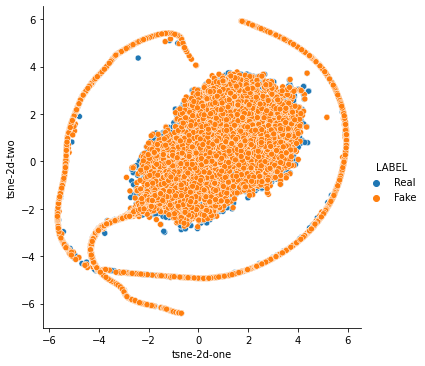

In [55]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.relplot(x='tsne-2d-one', y='tsne-2d-two', data=df, hue='LABEL')